In [ ]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)


In [ ]:
# import tensorflow as tf
# import tensorflow.keras  
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()  
# config.gpu_options.allow_growth = True 
# sess = tf.Session(config=config)
# set_session(sess)
# keras.backend.clear_session() #清理session

In [1]:
from tqdm.notebook import tqdm
from time import sleep

for i in tqdm(range(100)):
    sleep(0.01)


  0%|          | 0/100 [00:00<?, ?it/s]

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:0'


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# 网上提到该设置可能有其他风险

In [3]:
import tensorflow as tf

In [4]:
import tensorflow as tf

tf.__version__

'1.15.0'

In [5]:
import os
from tensorflow.python.client import device_lib
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "99"
 
if __name__ == "__main__":
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12081540089237977208
]


In [6]:
# -*- coding: utf-8 -*-

#Hide the Configuration配置 and Warning
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

In [7]:
# Import the Used Packages: Numpy, Pandas, and Tensorflow
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
tf.compat.v1.reset_default_graph()

# Clear the Stack
tf.reset_default_graph()

In [8]:
# The Location of train_data，train_labels，test_data，test_labels 训练数据、标签，测试数据、标签的位置
# DataSet Address数据集地址 K:/Google_Driver/EEG_Features_For_Multi_class_Motor_Imagery/EEG_Test_Raw_Data/Changed_Excel_Data/
DIR = 'Data/'

# Model Saver Addressm模型存放地址 K:/Google_Driver/EEG_Features_For_Multi_class_Motor_Imagery/EEG_Test_Raw_Data/First_Try_Model/
SAVE = 'Model/'

# Activate a Session激活会话
sess = tf.InteractiveSession()

In [9]:
# 分类数和时间
n_class=3
n_time=560

# Read Training Data 读取训练数据
train_data = pd.read_csv(DIR + 'Training_data.csv', header=None, index_col=0)
train_data = np.array(train_data).astype('float32')
print(train_data.shape)

(2689, 560)


In [10]:
# Read Training Labels 读取训练标签
train_labels = pd.read_csv(DIR + 'Training_labels.csv', header=None, index_col=0)
train_labels = np.array(train_labels)
print(train_labels.shape)

(2689, 3)


In [11]:
# Read Testing Data 读取测试数据
test_data = pd.read_csv(DIR + 'Test_data.csv', header=None, index_col=0)
test_data = np.array(test_data).astype('float32')
print(test_data.shape)

(1152, 560)


In [12]:
# Read Testing Labels 读取测试标签
test_labels = pd.read_csv(DIR + 'Test_labels.csv', header=None, index_col=0)
test_labels = np.array(test_labels)
print(test_labels.shape)

(1152, 3)


In [13]:
# Set Batch Size 64 将batch大小设置为64
batch_size = 64
n_batch = train_data.shape[0] // batch_size

In [14]:
# Initialize the Weights 初始化权重
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

In [15]:
# Initialize the Bias 初始化偏差
def bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)

In [16]:
# Define the Function of Summary 定义summary的功能
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)

        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('stddev', stddev)

        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
        #scalar标量；histogram柱状图

In [17]:
# Define Placeholders 定义占位符
with tf.name_scope("Input"):
    # x is the input feature data  x是输入特征数据
    with tf.name_scope("Input_Data"):
        x = tf.placeholder(tf.float32, [None, n_time])       ##修改  640  ？

    # y is the label related to the data y是数据标签
    with tf.name_scope("Labels"):
        y = tf.placeholder(tf.float32, [None, n_class])         #####  4？

    # Keep_Prob is the possibility that keep neural while using dropout 使用dropout保持神经功能，，概率
    with tf.name_scope("Keep_Prob"):
        keep_prob = tf.placeholder(tf.float32)

    # Reshape the input data into 2-dimensional  将输入数据重塑为2维
    with tf.name_scope("Reshape_Data"):
        x_Reshape = tf.reshape(tensor=x, shape=[-1, 28, 20, 1])  #[-1, 32, 20, 1]
        #tensor张量

卷积神经网络CNN 包含6个卷积层，两个最大池化层，两个全连接层。优点：省略特征提取步骤，直接输入经过预处理的数据，能够从大量数据中学习到高维特征。

数据集大小为[6460,560],训练与测试按照7:3的比例划分，[2689,1152], 560时间戳看做28×20的一张图片，一个样本大小是28×20×1，batch为64，使用的标签集已经处理过，原数据集每个时间戳都有标签，现已将事件戳标签合并为一个，改为每个通道一个标签，并处理为独热码，输出为3个类别，静息、左手、右手，最终大小为[6460,3]。使用adam优化器。

In [18]:
# First Convolutional Layer 第一卷积层
with tf.name_scope('Convolutional_1'):
    with tf.name_scope('W_conv1'):
        W_conv1 = weight_variable([3, 3, 1, 32])   #[3, 3, 1, 32]    权重
        # variable_summaries(W_conv1)

    with tf.name_scope('b_conv1'):
        b_conv1 = bias_variable([32])       #([32])    偏差
        # variable_summaries(b_conv1)

    with tf.name_scope('h_conv1'):
        h_conv1 = tf.nn.conv2d(x_Reshape, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1    #大小 28*20*32
        #strides 步长；；padding填充覆盖。
        # variable_summaries(h_conv1)

    with tf.name_scope('h_conv1_Acti'):
        h_conv1_Acti = tf.nn.leaky_relu(h_conv1)
        #leaky 有漏洞的
        # variable_summaries(h_conv1_Acti)

    with tf.name_scope('h_conv1_drop'):
        h_conv1_drop = tf.nn.dropout(h_conv1_Acti, keep_prob, noise_shape=[tf.shape(h_conv1_Acti)[0], 1, 1, tf.shape(h_conv1_Acti)[3]])
        # variable_summaries(h_conv1_drop)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
# Second Convolutional Layer 第二卷积层
with tf.name_scope('Convolutional_2'):
    with tf.name_scope('W_conv2'):
        W_conv2 = weight_variable([3, 3, 32, 32])  #
        # variable_summaries(W_conv2)

    with tf.name_scope('b_conv2'):
        b_conv2 = bias_variable([32])
        # variable_summaries(b_conv2)

    with tf.name_scope('h_conv2'):
        h_conv2 = tf.nn.conv2d(h_conv1_drop, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2   #大小 28*20*32
        # variable_summaries(h_conv2)

    with tf.name_scope('h_conv2_BN'):
        h_conv2_BN = tf.layers.batch_normalization(h_conv2, training=True)
        # variable_summaries(h_conv2_BN)

    with tf.name_scope('h_conv2_Acti'):
        h_conv2_Acti = tf.nn.leaky_relu(h_conv2_BN)
        # variable_summaries(h_conv2_Acti)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.


In [20]:
# Third Convolutional Layer 第三卷积层
with tf.name_scope('Convolutional_3'):
    with tf.name_scope('W_conv3'):
        W_conv3 = weight_variable([3, 3, 64, 64])  #28*20*64
        # variable_summaries(W_conv3)

    with tf.name_scope('b_conv3'):
        b_conv3 = bias_variable([64])
        # variable_summaries(b_conv3)

    with tf.name_scope('h_conv3_res'):
        h_conv3_res = tf.concat([h_conv2_Acti, h_conv1_drop], axis=3)
        # variable_summaries(h_conv3_res)

    with tf.name_scope('h_conv3'):
        h_conv3 = tf.nn.conv2d(h_conv3_res, W_conv3, strides=[1, 1, 1, 1], padding='SAME') + b_conv3   #28*20*64
        # variable_summaries(h_conv3)

    with tf.name_scope('h_conv3_Acti'):
        h_conv3_Acti = tf.nn.leaky_relu(h_conv3)
        # variable_summaries(h_conv3_Acti)

    with tf.name_scope('h_pool3_drop'):
        h_conv3_drop = tf.nn.dropout(h_conv3_Acti, keep_prob, noise_shape=[tf.shape(h_conv3_Acti)[0], 1, 1, tf.shape(h_conv3_Acti)[3]])
        # variable_summaries(h_conv3_drop)


In [21]:
# First Max Pooling Layer 第一最大池化层
with tf.name_scope('Pooling_1'):
    with tf.name_scope('h_pool3'):
        h_pool3 = tf.nn.max_pool(h_conv3_drop, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')   #14*10*64
        # variable_summaries(h_pool3)

In [22]:
# Fourth Convolutional Layer 第四卷积层
with tf.name_scope('Convolutional_4'):
    with tf.name_scope('W_conv4'):
        W_conv4 = weight_variable([3, 3, 64, 64])
        # variable_summaries(W_conv4)

    with tf.name_scope('b_conv4'):
        b_conv4 = bias_variable([64])
        # variable_summaries(b_conv4)

    with tf.name_scope('h_conv4'):
        h_conv4 = tf.nn.conv2d(h_pool3, W_conv4, strides=[1, 1, 1, 1], padding='VALID') + b_conv4    #12*8*64
        # variable_summaries(h_conv4)

    with tf.name_scope('h_conv4_BN'):
        h_conv4_BN = tf.layers.batch_normalization(h_conv4, training=True)
        # variable_summaries(h_conv4_BN)

    with tf.name_scope('h_conv4_Acti'):
        h_conv4_Acti = tf.nn.leaky_relu(h_conv4_BN)
        # variable_summaries(h_conv4_Acti)

    with tf.name_scope('h_conv4_drop'):
        h_conv4_drop = tf.nn.dropout(h_conv4_Acti, keep_prob, noise_shape=[tf.shape(h_conv4_Acti)[0], 1, 1, tf.shape(h_conv4_Acti)[3]])
        # variable_summaries(h_conv4_drop)

In [23]:
# Fifth Convolutional Layer 第五卷积层
with tf.name_scope('Convolutional_5'):
    with tf.name_scope('W_conv5'):
        W_conv5 = weight_variable([3, 3, 64, 64])
        # variable_summaries(W_conv5)

    with tf.name_scope('b_conv5'):
        b_conv5 = bias_variable([64])
        # variable_summaries(b_conv5)

    with tf.name_scope('h_conv5'):
        h_conv5 = tf.nn.conv2d(h_conv4_drop, W_conv5, strides=[1, 1, 1, 1], padding='SAME') + b_conv5      #12*8*64
        # variable_summaries(h_conv5)

    with tf.name_scope('h_conv5_BN'):
        h_conv5_BN = tf.layers.batch_normalization(h_conv5, training=True)
        # variable_summaries(h_conv5_BN)

    with tf.name_scope('h_conv5_Acti'):
        h_conv5_Acti = tf.nn.leaky_relu(h_conv5_BN)
        # variable_summaries(h_conv5_Acti)

In [24]:
# Sixth Convolutional Layer 第六卷积层
with tf.name_scope('Convolutional_6'):
    with tf.name_scope('W_conv6'):
        W_conv6 = weight_variable([3, 3, 128, 128])         #12*8*128
        # variable_summaries(W_conv6)

    with tf.name_scope('b_conv6'):
        b_conv6 = bias_variable([128])
        # variable_summaries(b_conv6)

    with tf.name_scope('h_conv6_res'):
        h_conv6_res = tf.concat([h_conv5_Acti, h_conv4_drop], axis=3)
        # variable_summaries(h_conv6_res)

    with tf.name_scope('h_conv6'):
        h_conv6 = tf.nn.conv2d(h_conv6_res, W_conv6, strides=[1, 1, 1, 1], padding='SAME') + b_conv6        #12*8*128
        # variable_summaries(h_conv6)

    with tf.name_scope('h_conv6_Activation'):
        h_conv6_Acti = tf.nn.leaky_relu(h_conv6)
        # variable_summaries(h_conv6_Acti)

    with tf.name_scope('h_pool6_drop'):
        h_conv6_drop = tf.nn.dropout(h_conv6_Acti, keep_prob, noise_shape=[tf.shape(h_conv6_Acti)[0], 1, 1, tf.shape(h_conv6_Acti)[3]])
        # variable_summaries(h_conv6_drop)

In [25]:
# Second Max Pooling Layer 第二最大池化层
with tf.name_scope('Pooling_2'):
    with tf.name_scope('h_pool6'):
        h_pool6 = tf.nn.max_pool(h_conv6_drop, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')      #6*4*128
        # variable_summaries(h_pool6)

In [26]:
# Flatten Layer压平
with tf.name_scope('Flatten'): 
    with tf.name_scope('h_pool6_flat'):
        h_pool6_flat = tf.reshape(h_pool6, [-1, 6 * 4 * 128])  #-1, 4 * 7 * 128
        # variable_summaries(h_pool6_flat)
        
#Convolution卷积层之后是无法直接连接Dense全连接层的，需要把Convolution层的数据压平（Flatten），然后就可以直接加Dense层了。
#也就是把 (height,width,channel)的数据压缩成长度为 height × width × channel 的一维数组，然后再与 FC层连接，这之后就跟普通的神经网络无异了。

In [27]:
# First Fully Connected Layer 第一全连接层
with tf.name_scope('Fully_Connected_1'):
    with tf.name_scope('W_fc1'):
        W_fc1 = weight_variable([4 * 6 * 128, 512])    # [4 * 7 * 128, 512]
        # variable_summaries(W_fc1)

    with tf.name_scope('b_fc1'):
        b_fc1 = bias_variable([512])
        # variable_summaries(b_fc1)

    with tf.name_scope('h_fc1'):
        h_fc1 = tf.matmul(h_pool6_flat, W_fc1) + b_fc1
        # variable_summaries(h_fc1)

    with tf.name_scope('h_fc1_BN'):
        h_fc1_BN = tf.layers.batch_normalization(h_fc1, training=True)
        # variable_summaries(h_fc1_BN)

    with tf.name_scope('h_fc1_Acti'):
        h_fc1_Acti = tf.nn.leaky_relu(h_fc1_BN)
        # variable_summaries(h_fc1_Acti)

    with tf.name_scope('h_fc1_drop'):
        h_fc1_drop = tf.nn.dropout(h_fc1_Acti, keep_prob)
        # variable_summaries(h_fc1_drop)

In [28]:
# Second Fully Connected Layer 第二全连接层
with tf.name_scope('Output_Layer'):
    with tf.name_scope('W_fc2'):
        W_fc2 = weight_variable([512, 3])  #gai 512, 4
        # variable_summaries(W_fc2)

    with tf.name_scope('b_fc2'):
        b_fc2 = bias_variable([3])   #[4] gai
        # variable_summaries(b_fc2)

    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
        # variable_summaries(prediction)
        #预测

In [29]:
# Define Loss Function 定义损失函数
with tf.name_scope('loss'):
    with tf.name_scope('Euclidean_Distance'):
        loss = tf.reduce_mean(tf.square(y - prediction))
        tf.summary.scalar('loss', loss)

In [30]:
# Define Training Optimizer 定义训练优化器Adam
with tf.name_scope('Train_Optimizer'):
    train_step = tf.train.AdamOptimizer(1e-5).minimize(loss)

四个任务：
① 目标出现在屏幕的左侧或右侧。受试者打开和握紧相应的手，直到目标消失，然后受试者放松。
② 目标出现在屏幕的左侧或右侧。受试者想象张开和握紧相应的手，直到目标消失，然后受试者放松。
③ 目标出现在屏幕的顶部或底部。受试者打开或握紧两只手(如果目标在顶部)，直到目标消失。然后受试者放松。
④ 目标出现在屏幕的顶部或底部。受试者想象打开和握紧两只手(如果目标在顶部)，直到目标消失。然后受试者放松。
本次实验中，我们选择一个测试者S01的两次测试一共六十个任务，每个任务有4秒的时间，采样频率为160次/秒，采集64个通道的数据。测试者的状态包括T0：静息态，T1：想象左手松开/握紧，T2：想象右手松开/握紧。

本实验使用accuracy, recall, precision，F-score四个指标对模型性能进行评估。

准确率（accuracy）, 所有的预测正确（正类负类）的占总的比重，准确率越高，意味着模型整体的预测准确程度；

精确率（也叫查准率，precision), 即正确预测为正的占全部预测为正的比例，（真正正确的占所有预测为正的比例），精确率越高，意味着正样本中预测准确度越高；

召回率（recall）, 即正确预测为正的占全部实际为正的比例（真正正确的占所有实际为正的比例）；

F-score值，F1值为算数平均数除以几何平均数，且越大越好，将Precision和Recall的上述公式带入会发现，当F1-score值小时，True Positive相对增加，而false相对减少，即Precision和Recall都相对增加，即F1-score对Precision和Recall都进行了加权。一般来说准确率和召回率呈负相关，一个高，一个就低，如果两个都低，一定是有问题的。一般来说，精确度和召回率之间是矛盾的，这里引入F1-Score作为综合指标，就是为了平衡准确率和召回率的影响，较为全面地评价一个分类器。

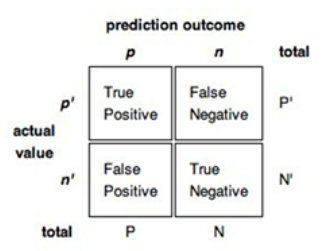

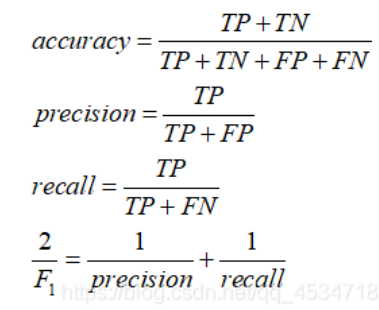

In [31]:
# Calculate Accuracy 计算准确率
# Add metrics to TensorBoard. 添加指标
with tf.name_scope('Evalution'):
    # Calculate Each Task Accuracy计算每个任务的准确率
    with tf.name_scope('Each_Class_accuracy'):
        # Task 1 Accuracy 任务1的准确率
        with tf.name_scope('T1_accuracy'):
            # Number of Classified Correctly 分类正确的数量
            y_T1 = tf.equal(tf.argmax(y, 1), 0)
            prediction_T1 = tf.equal(tf.argmax(prediction, 1), 0)
            T1_Corrected_Num = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T1, prediction_T1), tf.float32))

            # Number of All the Test Samples  所有测试样本的数量
            T1_all_Num = tf.reduce_sum(tf.cast(y_T1, tf.float32))

            # Task 1 Accuracy 任务1的准确率
            T1_accuracy = tf.divide(T1_Corrected_Num, T1_all_Num)
            tf.summary.scalar('T1_accuracy', T1_accuracy)

            T1_TP = T1_Corrected_Num
            T1_TN = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_T1), tf.math.logical_not(prediction_T1)), tf.float32))
            T1_FP = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_T1), prediction_T1), tf.float32))
            T1_FN = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T1, tf.math.logical_not(prediction_T1)), tf.float32))
            #TP 真阳性
            #FP 伪阳性
            #TN 真阴性
            #FN 伪阴性

            with tf.name_scope("T1_Precision"):
                T1_Precision = T1_TP / (T1_TP + T1_FP)
                tf.summary.scalar('T1_Precision', T1_Precision)

            with tf.name_scope("T1_Recall"):
                T1_Recall = T1_TP / (T1_TP + T1_FN)
                tf.summary.scalar('T1_Recall', T1_Recall)

            with tf.name_scope("T1_F_Score"):
                T1_F_Score = (2*T1_Precision*T1_Recall)/(T1_Precision+T1_Recall)
                tf.summary.scalar('T1_F_Score', T1_F_Score)

In [32]:
 # Task 2 Accuracy 任务2的准确率
        with tf.name_scope('T2_accuracy'):
            # Number of Classified Correctly 分类正确的数量
            y_T2 = tf.equal(tf.argmax(y, 1), 1)
            prediction_T2 = tf.equal(tf.argmax(prediction, 1), 1)
            T2_Corrected_Num = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T2, prediction_T2), tf.float32))

            # Number of All the Test Samples 所有测试样本的数量
            T2_all_Num = tf.reduce_sum(tf.cast(y_T2, tf.float32))

            # Task 2 Accuracy 任务2的准确率
            T2_accuracy = tf.divide(T2_Corrected_Num, T2_all_Num)
            tf.summary.scalar('T2_accuracy', T2_accuracy)

            T2_TP = T2_Corrected_Num
            T2_TN = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_T2), tf.math.logical_not(prediction_T2)), tf.float32))
            T2_FP = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_T2), prediction_T2), tf.float32))
            T2_FN = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T2, tf.math.logical_not(prediction_T2)), tf.float32))

            with tf.name_scope("T2_Precision"):
                T2_Precision = T2_TP / (T2_TP + T2_FP)
                tf.summary.scalar('T2_Precision', T2_Precision)

            with tf.name_scope("T2_Recall"):
                T2_Recall = T2_TP / (T2_TP + T2_FN)
                tf.summary.scalar('T2_Recall', T2_Recall)

            with tf.name_scope("T2_F_Score"):
                T2_F_Score = (2*T2_Precision*T2_Recall)/(T2_Precision+T2_Recall)
                tf.summary.scalar('T2_F_Score', T2_F_Score)

In [33]:
 # Task 3 Accuracy
        with tf.name_scope('T3_accuracy'):
            # Number of Classified Correctly
            y_T3 = tf.equal(tf.argmax(y, 1), 2)
            prediction_T3 = tf.equal(tf.argmax(prediction, 1), 2)
            T3_Corrected_Num = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T3, prediction_T3), tf.float32))

            # Number of All the Test Samples
            T3_all_Num = tf.reduce_sum(tf.cast(y_T3, tf.float32))

            # Task 3 Accuracy
            T3_accuracy = tf.divide(T3_Corrected_Num, T3_all_Num)
            tf.summary.scalar('T3_accuracy', T3_accuracy)

            T3_TP = T3_Corrected_Num
            T3_TN = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_T3), tf.math.logical_not(prediction_T3)), tf.float32))
            T3_FP = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_T3), prediction_T3), tf.float32))
            T3_FN = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T3, tf.math.logical_not(prediction_T3)), tf.float32))

            with tf.name_scope("T3_Precision"):
                T3_Precision = T3_TP / (T3_TP + T3_FP)
                tf.summary.scalar('T3_Precision', T3_Precision)

            with tf.name_scope("T3_Recall"):
                T3_Recall = T3_TP / (T3_TP + T3_FN)
                tf.summary.scalar('T3_Recall', T3_Recall)

            with tf.name_scope("T3_F_Score"):
                T3_F_Score = (2*T3_Precision*T3_Recall)/(T3_Precision+T3_Recall)
                tf.summary.scalar('T3_F_Score', T3_F_Score)

In [ ]:
 # Task 4 Accuracy
        # with tf.name_scope('T4_accuracy'):
        #     # Number of Classified Correctly
        #     y_T4 = tf.equal(tf.argmax(y, 1), 3)
        #     prediction_T4 = tf.equal(tf.argmax(prediction, 1), 3)
        #     T4_Corrected_Num = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T4, prediction_T4), tf.float32))
        #
        #     # Number of All the Test Samples
        #     T4_all_Num = tf.reduce_sum(tf.cast(y_T4, tf.float32))
        #
        #     # Task 4 Accuracy
        #     T4_accuracy = tf.divide(T4_Corrected_Num, T4_all_Num)
        #     tf.summary.scalar('T4_accuracy', T4_accuracy)
        #
        #     T4_TP = T4_Corrected_Num
        #     T4_TN = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_T4), tf.math.logical_not(prediction_T4)), tf.float32))
        #     T4_FP = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_T4), prediction_T4), tf.float32))
        #     T4_FN = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T4, tf.math.logical_not(prediction_T4)), tf.float32))
        #
        #     with tf.name_scope("T4_Precision"):
        #         T4_Precision = T4_TP / (T4_TP + T4_FP)
        #         tf.summary.scalar('T4_Precision', T4_Precision)
        #
        #     with tf.name_scope("T4_Recall"):
        #         T4_Recall = T4_TP / (T4_TP + T4_FN)
        #         tf.summary.scalar('T4_Recall', T4_Recall)
        #
        #     with tf.name_scope("T4_F_Score"):
        #         T4_F_Score = (2*T4_Precision*T4_Recall)/(T4_Precision+T4_Recall)
        #         tf.summary.scalar('T4_F_Score', T4_F_Score)

In [34]:
 # Calculate the Confusion Matrix 计算混淆矩阵
    with tf.name_scope("Confusion_Matrix"):
        with tf.name_scope("T1_Label"):
            T1_T1 = T1_Corrected_Num
            T1_T2 = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T1, prediction_T2), tf.float32))
            T1_T3 = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T1, prediction_T3), tf.float32))
            # T1_T4 = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T1, prediction_T4), tf.float32))

            T1_T1_percent = tf.divide(T1_T1, T1_all_Num)
            T1_T2_percent = tf.divide(T1_T2, T1_all_Num)
            T1_T3_percent = tf.divide(T1_T3, T1_all_Num)
            # T1_T4_percent = tf.divide(T1_T4, T1_all_Num)

            tf.summary.scalar('T1_T1_percent', T1_T1_percent)
            tf.summary.scalar('T1_T2_percent', T1_T2_percent)
            tf.summary.scalar('T1_T3_percent', T1_T3_percent)
            # tf.summary.scalar('T1_T4_percent', T1_T4_percent)

        with tf.name_scope("T2_Label"):
            T2_T1 = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T2, prediction_T1), tf.float32))
            T2_T2 = T2_Corrected_Num
            T2_T3 = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T2, prediction_T3), tf.float32))
            # T2_T4 = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T2, prediction_T4), tf.float32))

            T2_T1_percent = tf.divide(T2_T1, T2_all_Num)
            T2_T2_percent = tf.divide(T2_T2, T2_all_Num)
            T2_T3_percent = tf.divide(T2_T3, T2_all_Num)
            # T2_T4_percent = tf.divide(T2_T4, T2_all_Num)

            tf.summary.scalar('T2_T1_percent', T2_T1_percent)
            tf.summary.scalar('T2_T2_percent', T2_T2_percent)
            tf.summary.scalar('T2_T3_percent', T2_T3_percent)
            # tf.summary.scalar('T2_T4_percent', T2_T4_percent)

        with tf.name_scope("T3_Label"):
            T3_T1 = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T3, prediction_T1), tf.float32))
            T3_T2 = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T3, prediction_T2), tf.float32))
            T3_T3 = T3_Corrected_Num
            # T3_T4 = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T3, prediction_T4), tf.float32))

            T3_T1_percent = tf.divide(T3_T1, T3_all_Num)
            T3_T2_percent = tf.divide(T3_T2, T3_all_Num)
            T3_T3_percent = tf.divide(T3_T3, T3_all_Num)
            # T3_T4_percent = tf.divide(T3_T4, T3_all_Num)

            tf.summary.scalar('T3_T1_percent', T3_T1_percent)
            tf.summary.scalar('T3_T2_percent', T3_T2_percent)
            tf.summary.scalar('T3_T3_percent', T3_T3_percent)
            # tf.summary.scalar('T3_T4_percent', T3_T4_percent)

In [ ]:
   # with tf.name_scope("T4_Label"):
        #     T4_T1 = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T4, prediction_T1), tf.float32))
        #     T4_T2 = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T4, prediction_T2), tf.float32))
        #     T4_T3 = tf.reduce_sum(tf.cast(tf.math.logical_and(y_T4, prediction_T3), tf.float32))
        #     T4_T4 = T4_Corrected_Num
        #
        #     T4_T1_percent = tf.divide(T4_T1, T4_all_Num)
        #     T4_T2_percent = tf.divide(T4_T2, T4_all_Num)
        #     T4_T3_percent = tf.divide(T4_T3, T4_all_Num)
        #     T4_T4_percent = tf.divide(T4_T4, T4_all_Num)
        #
        #     tf.summary.scalar('T4_T1_percent', T4_T1_percent)
        #     tf.summary.scalar('T4_T2_percent', T4_T2_percent)
        #     tf.summary.scalar('T4_T3_percent', T4_T3_percent)
        #     tf.summary.scalar('T4_T4_percent', T4_T4_percent)

In [35]:
  with tf.name_scope('Global_Evalution_Metrics'):
        # Global Average Accuracy - Simple Algorithm 全局平均精度-简单算法
        with tf.name_scope('Global_Average_Accuracy'):
            correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            Global_Average_Accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            tf.summary.scalar('Global_Average_Accuracy', Global_Average_Accuracy)

        with tf.name_scope('Kappa_Metric'):
            Test_Set_Num = T1_all_Num + T2_all_Num + T3_all_Num   # T4_all_Num

            Actual_T1 = T1_all_Num
            Actual_T2 = T2_all_Num
            Actual_T3 = T3_all_Num
            # Actual_T4 = T4_all_Num

            Prediction_T1 = T1_T1 + T2_T1 + T3_T1    #T1_T1 + T2_T1 + T3_T1 + T4_T1
            Prediction_T2 = T1_T2 + T2_T2 + T3_T2     #T1_T2 + T2_T2 + T3_T2 + T4_T2
            Prediction_T3 = T1_T3 + T2_T3 + T3_T3    #T1_T3 + T2_T3 + T3_T3 + T4_T3
            # Prediction_T4 = T1_T4 + T2_T4 + T3_T4 + T4_T4

            p0 = (T1_T1 + T2_T2 + T3_T3) / Test_Set_Num   #(T1_T1 + T2_T2 + T3_T3 + T4_T4) / Test_Set_Num
            pe = (Actual_T1*Prediction_T1 + Actual_T2*Prediction_T2 + Actual_T3*Prediction_T3) / \
                 (Test_Set_Num*Test_Set_Num)   #(Actual_T1*Prediction_T1 + Actual_T2*Prediction_T2 + Actual_T3*Prediction
                                               # _T3 + Actual_T4*Prediction_T4)

            Kappa_Metric = (p0 - pe) / (1 - pe)
            tf.summary.scalar('Kappa_Metric', Kappa_Metric)

        with tf.name_scope('Micro_Averaged_Evalution'):
            with tf.name_scope("Micro_Averaged_Confusion_Matrix"):
                TP_all = T1_TP + T2_TP + T3_TP       #T1_TP + T2_TP + T3_TP + T4_TP
                TN_all = T1_TN + T2_TN + T3_TN   #T1_TN + T2_TN + T3_TN + T4_TN
                FP_all = T1_FP + T2_FP + T3_FP     #T1_FP + T2_FP + T3_FP + T4_FP
                FN_all = T1_FN + T2_FN + T3_FN      #T1_FN + T2_FN + T3_FN + T4_FN

            with tf.name_scope("Micro_Global_Precision"):
                Micro_Global_Precision = TP_all / (TP_all + FP_all)
                tf.summary.scalar('Micro_Global_Precision', Micro_Global_Precision)

            with tf.name_scope("Micro_Global_Recall"):
                Micro_Global_Recall = TP_all / (TP_all + FN_all)
                tf.summary.scalar('Micro_Global_Recall', Micro_Global_Recall)

            with tf.name_scope("Micro_Global_F1_Score"):
                Micro_Global_F1_Score = (2*Micro_Global_Precision*Micro_Global_Recall)/(Micro_Global_Precision+Micro_Global_Recall)
                tf.summary.scalar('Micro_Global_F1_Score', Micro_Global_F1_Score)

        with tf.name_scope('Macro_Averaged_Evalution'):
            with tf.name_scope("Macro_Global_Precision"):
                Macro_Global_Precision = (T1_Precision + T2_Precision + T3_Precision) / 3
                #(T1_Precision + T2_Precision + T3_Precision + T4_Precision) / 4
                tf.summary.scalar('Macro_Global_Precision', Macro_Global_Precision)

            with tf.name_scope("Macro_Global_Recall"):
                Macro_Global_Recall = (T1_Recall + T2_Recall + T3_Recall) / 3
                #T1_Recall + T2_Recall + T3_Recall + T4_Recall
                tf.summary.scalar('Macro_Global_Recall', Macro_Global_Recall)

            with tf.name_scope("Macro_Global_F1_Score"):
                Macro_Global_F1_Score = (T1_F_Score + T2_F_Score + T3_F_Score) / 3
                #(T1_F_Score + T2_F_Score + T3_F_Score + T4_F_Score) / 4
                tf.summary.scalar('Macro_Global_F1_Score', Macro_Global_F1_Score)

In [ ]:
# import tensorflow as tf
# import tensorflow.keras  
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()  
# config.gpu_options.allow_growth = True 
# sess = tf.Session(config=config)
# set_session(sess)
# keras.backend.clear_session() #清理session

Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
无法获取卷积算法。这可能是因为cuDNN未能初始化，所以请尝试查看上面是否打印了警告日志消息。
开头开启的用来限制显存的session由于没有清理，用keras里的clear_session()清理一下session就OK了。

In [38]:
# Merge all the summaries #合并所有摘要
merged = tf.summary.merge_all()

# Initialize all the variables 初始化所有变量
sess.run(tf.global_variables_initializer())

# Start a saver to save the trained model 启动一个保存程序来保存经过训练的模型
saver = tf.train.Saver()

# Summary the Training and Test Processing 总结训练和测试过程
train_writer = tf.summary.FileWriter(SAVE + 'train_Writer', sess.graph)
test_writer  = tf.summary.FileWriter(SAVE + 'test_Writer')

loss_his=[]
acc_his=[]
for epoch in range(501):
    for batch_index in range(n_batch):
        random_batch = random.sample(range(train_data.shape[0]), batch_size)
        batch_xs = train_data[random_batch]
        batch_ys = train_labels[random_batch]
        sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 0.50})

缩进错误：意外缩进。解决办法：if及之前顶格。

In [54]:
 # Accuracy on Training Set 训练集的准确率
train_acc, train_loss = sess.run([Global_Average_Accuracy, loss], feed_dict={x: train_data, y: train_labels, keep_prob: 0.5})
loss_his.append(train_loss)
acc_his.append(train_acc)
if epoch%10==0:
    print("Iter"+str(epoch)+",Training Accuracy: " + str(train_acc) + ", Trainging Loss: " + str(train_loss))
    print('accuracy=',train_acc)

Iter500,Training Accuracy: 0.99070287, Trainging Loss: 0.0066016554
accuracy= 0.99070287


In [55]:
 # Accuracy on Test Set 测试集的准确率
    test_summary, test_acc, test_loss = sess.run([merged, Global_Average_Accuracy, loss], feed_dict={x: test_data, y: test_labels, keep_prob: 0.5})
    test_writer.add_summary(test_summary, epoch)
    print('test_loss=',test_loss,',test_accuracy=',test_acc)

test_loss= 0.033565164 ,test_accuracy= 0.9331597


In [ ]:
  # Show the Model Capability 展示模型能力
    # print("Iter " + str(epoch) + ", Training Accuracy: " + str(train_acc) + ", Testing Accuracy: " + str(test_acc))


In [57]:
  # Save the Model Every 500 Epoches
if epoch % 100 == 0:
        saver.save(sess, save_path=SAVE + 'Model_Saver/Ite_%s' % epoch)

    # if epoch == 200:
    #     output_prediction = sess.run(prediction, feed_dict={x: test_data, y: test_labels, keep_prob: 1.0})
    #     np.savetxt(SAVE + "prediction.csv", output_prediction, delimiter=",")
    #     np.savetxt(SAVE + "labels.csv", int(test_labels), delimiter=",")
train_writer.close()
test_writer.close()
sess.close()

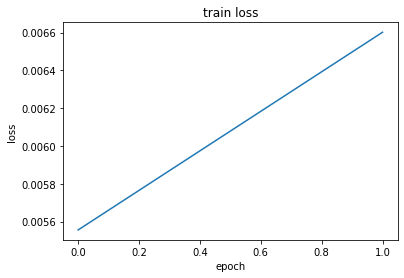

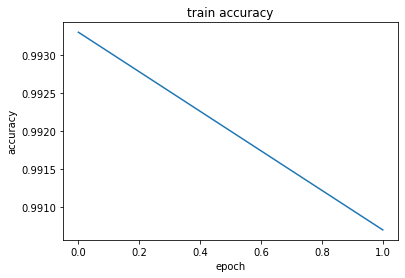

In [58]:
#画图
x1=range(len(loss_his))
y1=loss_his
x2=range(len(acc_his))
y2=acc_his

plt.figure(1)
plt.plot(x1,y1)
plt.title('train loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure(2)
plt.plot(x2,y2)
plt.title('train accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()